In [1]:
from utk_functions import data_train_test_utk

X_train, X_test, Y_train, Y_test, sensitive, sensitive_t = data_train_test_utk()

2024-06-20 18:35:37.651399: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 18:35:37.655762: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 18:35:40.259482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("hello")

hello


In [3]:
from common.functions import *

In [10]:
training_lambda = 0.0
sensitive_categorical = tf.keras.utils.to_categorical(sensitive)
model = get_fairness_lucasnet_model(
    pia_adv,
    input_set,
    sensitive=sensitive_categorical,
    training_lambda=training_lambda,
    num_classes=2,
    input_shape=(64, 64, 3))
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])#, model.p_rule_metric, model.adversary_metric])

In [11]:
hist = model.fit(
    X_train,
    Y_train,
    epochs=2,
    validation_data=(X_test, Y_test),
    batch_size=X_train.shape[0],
    #verbose=0
    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
)

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - accuracy: 0.4644 - loss: 0.0000e+00 - val_accuracy: 0.5242 - val_loss: 8.0007
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.5211 - loss: 0.0000e+00 - val_accuracy: 0.7038 - val_loss: 1.6550


In [ ]:


patience = 5
decrease = 0
best_val_acc = 0
best_model_weights = None
my_history = {
    'accuracy': [],
    'val_accuracy': [],
    'p_rule': [],
    'adversary_prediction': []
}

for i in range(100):
    hist = model.fit(
        X_train,
        Y_train,
        epochs=1,
        validation_data=(X_test, Y_test),
        batch_size=X_train.shape[0],
        verbose=0
        #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
    )
    
    # check pia adversary output
    y_pred_for_adv = model(model.adv_input)
    # last column of prediction is redundant
    num_columns = y_pred_for_adv.shape[1]-1
    y_pred_for_adv = y_pred_for_adv[:, 0:num_columns]
    y_pred_for_adv = Flatten()(y_pred_for_adv)
    # reshape as model input
    my_x = tf.reshape(y_pred_for_adv, (1, y_pred_for_adv.shape[0]*y_pred_for_adv.shape[1]))

    adversary_prediction = model.pia_adversary(my_x)[0][0]
    p_rule_value = model.p_rule(model(X_train, training=False), model.sensitive)
    
    val_acc = hist.history['val_accuracy'][-1]
    print(f"ROUND {i} acc: {hist.history['accuracy'][-1]} val_acc: {val_acc} + p_rule: {p_rule_value} adv_pred: {adversary_prediction}")
    
    for k, v in zip(my_history.keys(), [hist.history['accuracy'][-1], val_acc, p_rule_value, adversary_prediction]):
        my_history[k].append(v)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        decrease = 0
        best_model_weights = model.get_weights()
    else:
        decrease += 1
        if decrease >= patience:
            print("STOPPING")
            break
    
    

In [ ]:
my_history['p_rule'][0].numpy()

In [ ]:

new_hist = {
    'accuracy': my_history['accuracy'],
    'val_accuracy': my_history['val_accuracy'],
    'p_rule': [float(v.numpy()) for v in my_history['p_rule']],
    'adversary_prediction': [float(v.numpy()) for v in my_history['adversary_prediction']]
}

In [ ]:
import json



with open('simpletest.json', 'w') as json_file:
    json.dump(new_hist, json_file)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, training_lambda):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['p_rule'])
    plt.plot(history.history['adversary_prediction'])
    plt.title(f'Lambda {training_lambda}: Acc, p_rule, pia_adv')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train acc', 'Test acc', 'p-rule', 'adversary prediction'], loc='upper left')
    plt.show()


In [ ]:
model_history.history

In [ ]:
plot_history(model_history, training_lambda)

In [ ]:
X_train.shape

In [4]:
import keras

manual_adversary = keras.Sequential()
manual_adversary.add(keras.Input(shape=(13233,)))
#manual_adversary.add(keras.layers.Dropout(0.2))
manual_adversary.add(keras.layers.Dense(10, activation='relu'))
#manual_adversary.add(keras.layers.Dropout(0.05))
manual_adversary.add(keras.layers.Dense(5, activation='relu'))
#manual_adversary.add(keras.layers.Dropout(0.1))
manual_adversary.add(keras.layers.Dense(1))
manual_adversary.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.R2Score()])

In [5]:
pia_adv = manual_adversary

In [6]:
pia_adv.load_weights("utkface/models/manual_tuning_checkpoints-2/keras.weights.h5")

/informatik2/svs/home/stock/anaconda3/envs/pia-tf2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [7]:
from utk_functions import get_lbfw_dataset

input_set = get_lbfw_dataset()

In [ ]:
pd.array(sensitive).value_counts().iloc[0] / len(sensitive)

In [ ]:
model_l0 = model

In [ ]:
model_l0 = model

In [ ]:
pred_0 = model_l0(X_train)

In [ ]:
pred_01 = model_l01(X_train)

In [ ]:
adv_pred = model.adversary(np.reshape(pred, (30000, 10)))

In [ ]:
adv_pred

In [ ]:
sensitive

In [ ]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [ ]:
p_rule(pred_0.numpy(), sensitive) # lambda = 0.0

In [ ]:
p_rule(pred_01.numpy(), sensitive) # lambda = 0.1

In [ ]:
pred_01.shape

In [ ]:
sensitive.shape

In [ ]:
pred_01[sensitive == 1] > 0.5# if threshold else y_pred[sensitive == 1]

In [ ]:
for p in pred_01[:10]:
    # return index of element with highest value in p:
    print(np.argmax(p))

## results

In [3]:
training_lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
runs = range(10) ## PRELIMINARY
dists = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
resultspath = 'utkface/results/fairness-4/'

#all_results = [json.loads(open(f'{resultspath}result-l{l}-d{d}-r{r}.json').read()) for l in training_lambdas for r in runs for d in dists]

In [5]:
np.repeat([0.1, 0.2], 3)

array([0.1, 0.1, 0.1, 0.2, 0.2, 0.2])

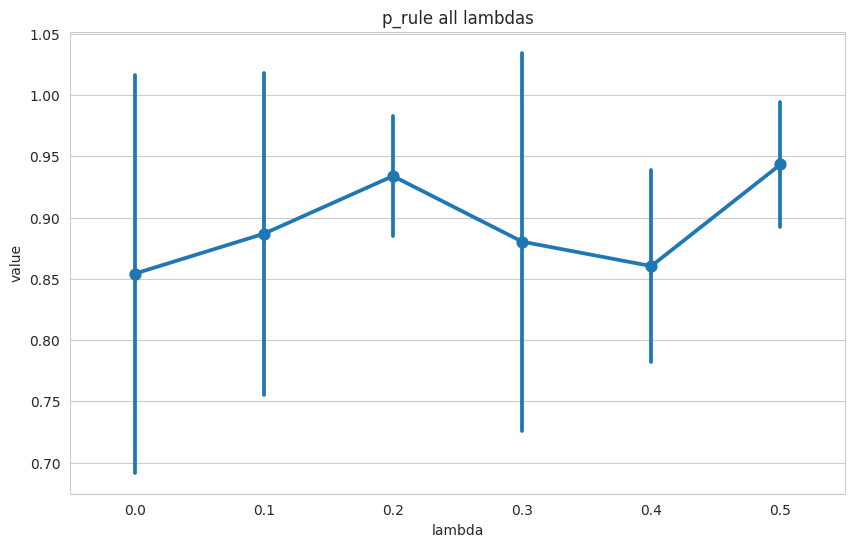

In [8]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

all_target_values = []
target = 'p_rule'
for l in training_lambdas:
    target_values = []
    for d in [0.7]: #dists:
        for r in runs:
            data = json.loads(open(f'{resultspath}result-l{l}-d{d}-r{r}.json').read())
            sums = np.array(data['p_rule'])# + 1.2 * np.array(data['val_accuracy'])
            max_index = np.argmax(sums)
            p_rules = data[target][max_index]
            target_values.append(p_rules)
    
        all_target_values.append(target_values)
        
    #df = pd.DataFrame({
    #    'value': target_values,
    #    'distributions': np.repeat(dists, len(runs))
    #})
    

    # Create the plot
    #plt.figure(figsize=(10, 6))
    #plt.title(f'{target} lambda={l}')
    #sns.pointplot(data=df, x='distributions', y='value', errorbar='sd')
    #plt.show()
    
dff = pd.DataFrame({
    'value': [item for sublist in all_target_values for item in sublist],
    'lambda': np.repeat(training_lambdas, len(runs)),
})
plt.figure(figsize=(10, 6))
plt.title(f'{target} all lambdas')
sns.pointplot(data=dff, x='lambda', y='value', errorbar='sd')
plt.show()

In [16]:
all_p_rules

[0.61962890625,
 0.787109375,
 0.9677734375,
 0.97265625,
 0.83154296875,
 0.93359375,
 0.40478515625,
 0.95361328125,
 0.92626953125,
 0.9248046875,
 0.87548828125,
 0.9287109375]

In [ ]:
p_rules

In [ ]:
results_l0_d03 = [json.loads(open(f'{resultspath}result-l0.0-d0.3-r{r}.json').read()) for r in runs]

In [ ]:
df = pd.DataFrame({
    'value': [item for sublist in results_l0_d03 for item in sublist['val_accuracy']],
    'epoch': [i for sublist in results_l0_d03 for i in range(len(sublist['val_accuracy']))],
})

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

training_lambdas = [0.0, 0.05, 0.1, 0.15]
runs = range(10)
dists = [0.3, 0.5, 0.7]
resultspath = 'utkface/results/fairness/'
target = 'val_accuracy'

for l in training_lambdas:
    for d in dists:
        results = [json.loads(open(f'{resultspath}result-l{l}-d{d}-r{r}.json').read()) for r in runs]

        df = pd.DataFrame({
            'value': [item for sublist in results for item in sublist[target]],
            'epoch': [i for sublist in results for i in range(len(sublist[target]))],
        })
#results_l0_d03 = [json.loads(open(f'{resultspath}result-l0.0-d0.3-r{r}.json').read()) for r in runs]

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.title(f'{target} lambda={l} dist={d}')
        sns.pointplot(data=df, x='epoch', y='value', errorbar='sd')
        plt.show()